We are using PPO to execute reinforcement learning of IMDB movies.

In [1]:
!pip install trl==0.11.3
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from tqdm import tqdm

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

import matplotlib.pyplot as plt

In [3]:
# Disable WAND
import os
os.environ["WANDB_MODE"] = "disabled"

Load the IMDB dataset that has positive and negative reviews. The goal of PPO is to move away from negative reviews.

In [9]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds


def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

config = PPOConfig(
  model_name="lvwerra/gpt2-imdb",
  learning_rate=1.41e-5,
  log_with=None,
)

dataset = build_dataset(config)

/usr/local/lib/python3.11/dist-packages/trl/trainer/ppo_config.py:207: FutureWarning: `PPOConfig` is deprecated and will be removed in the future. Please use `PPOv2Config` with `PPOv2Trainer` instead.
  warnings.warn(


Now load the pretrained model (fine tuned, but with no RL).

In [10]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

# We will freeze this model.
reference_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)

tokenizer = AutoTokenizer.from_pretrained(config.model_name)
tokenizer.pad_token = tokenizer.eos_token

ppo_trainer = PPOTrainer(
    config,
    model,
    reference_model,
    tokenizer,
    dataset=dataset,
    data_collator=collator
)

device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug

Set the reward model.

In [11]:
sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="lvwerra/distilbert-imdb",
    device=device
)

sent_kwargs = {
    "return_all_scores": True,
    "function_to_apply": "none",
    "batch_size": 16
}

output_min_length = 4
output_max_length = 16

# Set the length sampler thats going to be used during PPO training.
output_length_sampler = LengthSampler(output_min_length, output_max_length)

# The configuration to generate trajectories.
response_generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

Device set to use cuda:0


Begin training!

In [12]:
totals = []
lvalues = []
entropies = []

for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch["input_ids"]
    print(f"Current epoch {epoch}")

    # Feel free to exit on earlier epoch since the sequential training takes time.
    if epoch == 20:
        break

    # 1. Get trajectories from the offline policy.
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        response_generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **response_generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [
        tokenizer.decode(r.squeeze()) for r in response_tensors
    ]

    #2: Compute rewards.
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = [torch.tensor(output[1]["score"]) for output in pipe_outputs]

    #3: PPO update.
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

    #4: Gather some metrics.
    total = stats['ppo/loss/total']
    value = stats['ppo/loss/value']
    entropy = stats['ppo/policy/entropy']

    print(f"total = {total:.4f}")
    print(f"lvalue = {value:.4f}")
    print(f"entropy = {entropy:.4f}")

    totals.append(total)
    lvalues.append(value)
    entropies.append(entropy)

    ppo_trainer.log_stats(stats, batch, rewards)

print(totals)
print(lvalues)
print(entropies)

0it [00:00, ?it/s]

Current epoch 0


1it [00:15, 15.62s/it]

total = 0.0959
lvalue = 1.5498
entropy = 3.8723
Current epoch 1


2it [00:32, 16.32s/it]

total = 0.0939
lvalue = 1.3077
entropy = 3.8537
Current epoch 2


3it [00:48, 16.39s/it]

total = 0.1084
lvalue = 1.3860
entropy = 3.7796
Current epoch 3


4it [01:06, 16.93s/it]

total = 0.0991
lvalue = 1.2538
entropy = 3.7907
Current epoch 4


5it [01:24, 17.13s/it]

total = 0.0883
lvalue = 1.1383
entropy = 3.7155
Current epoch 5


6it [01:41, 17.16s/it]

total = 0.0833
lvalue = 1.0822
entropy = 3.6586
Current epoch 6


7it [01:58, 17.26s/it]

total = 0.0740
lvalue = 0.9660
entropy = 3.7012
Current epoch 7


8it [02:15, 16.94s/it]

total = 0.0634
lvalue = 0.8768
entropy = 3.6425
Current epoch 8


9it [02:33, 17.39s/it]

total = 0.0646
lvalue = 0.8724
entropy = 3.5651
Current epoch 9


10it [02:50, 17.28s/it]

total = 0.0705
lvalue = 0.9525
entropy = 3.6986
Current epoch 10


11it [03:08, 17.47s/it]

total = 0.0606
lvalue = 0.8312
entropy = 3.7102
Current epoch 11


12it [03:24, 17.13s/it]

total = 0.0517
lvalue = 0.7569
entropy = 3.6886
Current epoch 12


13it [03:41, 16.89s/it]

total = 0.0483
lvalue = 0.7142
entropy = 3.5865
Current epoch 13


14it [03:58, 16.91s/it]

total = 0.0536
lvalue = 0.7613
entropy = 3.6735
Current epoch 14


15it [04:15, 17.11s/it]

total = 0.0543
lvalue = 0.7674
entropy = 3.6839
Current epoch 15


16it [04:32, 17.11s/it]

total = 0.0526
lvalue = 0.7589
entropy = 3.6680
Current epoch 16


17it [04:50, 17.38s/it]

total = 0.0341
lvalue = 0.5449
entropy = 3.5941
Current epoch 17


18it [05:08, 17.42s/it]

total = 0.0440
lvalue = 0.6545
entropy = 3.6418
Current epoch 18


19it [05:25, 17.36s/it]

total = 0.0402
lvalue = 0.6297
entropy = 3.4854
Current epoch 19


20it [05:41, 17.10s/it]

total = 0.0642
lvalue = 0.8562
entropy = 3.5668
Current epoch 20
[0.09589359164237976, 0.09390907734632492, 0.10842335969209671, 0.09905286133289337, 0.08832325786352158, 0.08333370089530945, 0.07396890223026276, 0.06341156363487244, 0.06462286412715912, 0.07046481966972351, 0.06064651161432266, 0.05166873335838318, 0.04825591668486595, 0.05361571162939072, 0.05429680645465851, 0.052592337131500244, 0.03409784287214279, 0.04404854774475098, 0.040165264159440994, 0.06422063708305359]
[1.5498414039611816, 1.307681679725647, 1.3860485553741455, 1.2537517547607422, 1.1383235454559326, 1.0821856260299683, 0.965990424156189, 0.8768251538276672, 0.8724409341812134, 0.9524903297424316, 0.8311862945556641, 0.7569093704223633, 0.7142065167427063, 0.7612720727920532, 0.7674316167831421, 0.758918046951294, 0.544907808303833, 0.6545440554618835, 0.6296964883804321, 0.8562443256378174]
[3.8722708225250244, 3.8536882400512695, 3.7796435356140137, 3.7907047271728516, 3.7154922485351562, 3.658554553985

Graphs of the combined loss, the raw (V-Vo)² term and entropy

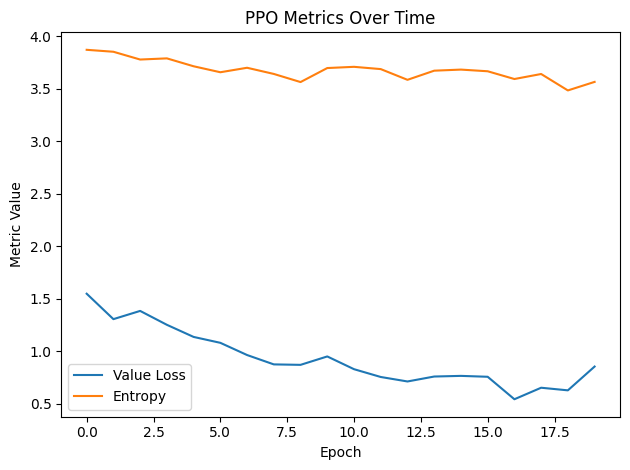

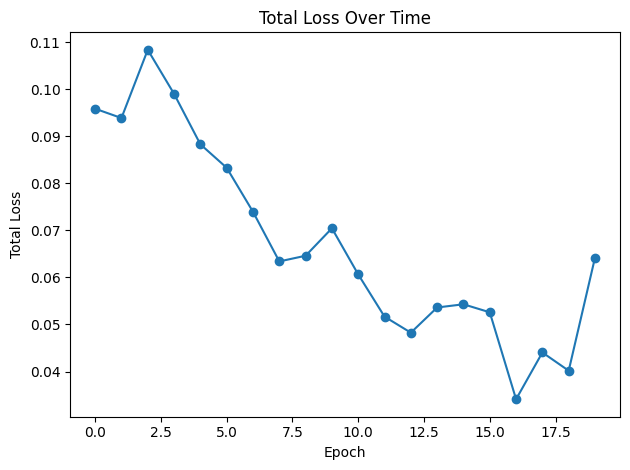

In [13]:
steps = list(range(len(totals)))

plt.figure()
plt.plot(steps, lvalues, label='Value Loss')
plt.plot(steps, entropies, label='Entropy')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('PPO Metrics Over Time')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(steps, totals, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Total Loss Over Time')
plt.tight_layout()
plt.show()